Please do one of the following.


# Part I: Classification

In [1]:
import pandas as pd
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from sklearn import svm
from sklearn.linear_model import Ridge

import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col = 0)

In [16]:
df.head(5)

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df_default = pd.get_dummies(df['default'])
df_default.rename(columns = {'Yes': 'default_Yes'}, inplace = True)

df_student = pd.get_dummies(df['student'])
df_student.rename(columns = {'Yes': 'student_Yes'}, inplace = True)

In [4]:
df_final = pd.concat([df_default[['default_Yes']], df_student[['student_Yes']], df[['balance','income']]],axis=1)
df_final['default_Yes'] = df_final.default_Yes.astype('category')
df_final['student_Yes'] = df_final.student_Yes.astype('category')

In [119]:
df_final.head(5)

,default_Yes,student_Yes,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

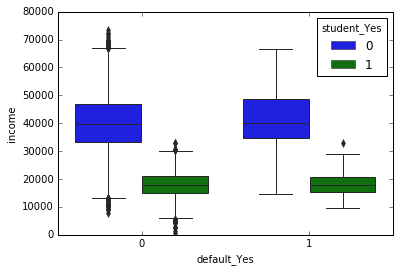

In [6]:
import seaborn as sns
sns.boxplot(x='default_Yes', y = 'income', hue = 'student_Yes', data = df_final)

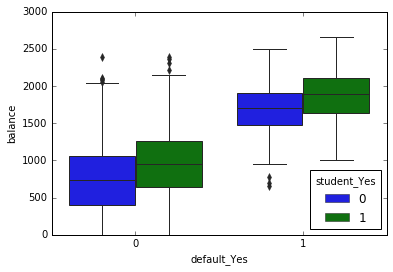

In [126]:
sns.boxplot(x='default_Yes', y = 'balance', hue = 'student_Yes', data = df_final)

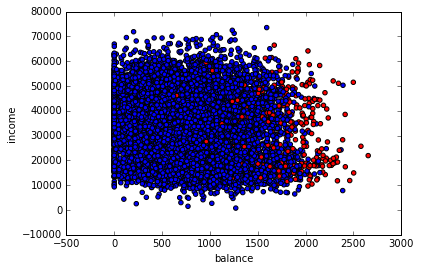

In [20]:
colors = {1:'red', 0:'blue'}
plt.scatter(df_final['balance'], df_final['income'], c=df_final['default_Yes'].apply(lambda x: colors[x]))
plt.xlabel('balance')
plt.ylabel('income')

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

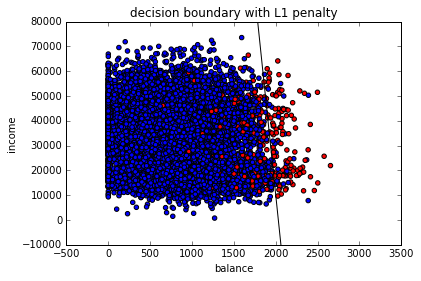

In [220]:
from sklearn.model_selection import train_test_split

students_df = df_final.loc[df_final['student_Yes'] == 1]
X = df_final[['balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 11)

logreg = LogisticRegression(penalty = 'l1')
logmodel = logreg.fit(X_train, y_train)

w = logreg.coef_[0]
a = -w[0]/w[1]

plt.scatter(df_final['balance'], df_final['income'], c=df_final['default_Yes'].apply(lambda x: colors[x]))
plt.xlabel('balance')
plt.ylabel('income')
xx = np.linspace(0, 3000)
yy = a*xx-(logreg.intercept_)/w[1]
plt.plot(xx, yy, c = "black")
plt.title("decision boundary with L1 penalty")
plt.ylim(-10000, 80000)
plt.show()

In [184]:
probas_ = logreg.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.941946


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [221]:
# include student variable
X = df_final[['student_Yes', 'balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

def generate_auc(X,y,clf_class,**kwargs):
    # Construct training and testing set.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state = 11)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
scores = []

# Optimize using ridge
for alpha in alphas: 
    fpr,tpr,roc_auc, thresholds = generate_auc(X, y, LogisticRegression, C=alpha, penalty='l2')
    scores.append(roc_auc)

alpha_best = alphas[np.argmax(scores)]
print("The optimal alpha is: %f" % alpha_best)

Area under the ROC curve : 0.932772
Area under the ROC curve : 0.940197
Area under the ROC curve : 0.942353
Area under the ROC curve : 0.943311
Area under the ROC curve : 0.943701
Area under the ROC curve : 0.943712
Area under the ROC curve : 0.943718
Area under the ROC curve : 0.943751
Area under the ROC curve : 0.943740
The optimal alpha is: 100.000000


In [225]:
X = df_final[['student_Yes', 'balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 11)

logregl2 = LogisticRegression(C = alpha_best, penalty = 'l2')

probas_ = logregl2.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve with ridge regression : %f" % roc_auc)

Area under the ROC curve with ridge regression : 0.943751


The AUC ROC using ridge and with the added student variable is slightly higher by 0.002.

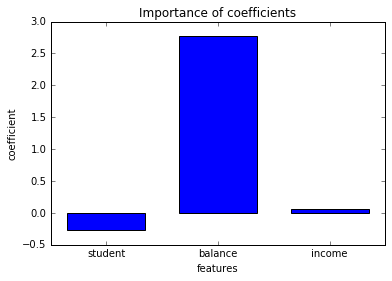

In [226]:
x = np.arange(3)

fig, ax = plt.subplots()
plt.bar(x, height = b_l2, width = 0.7, align = "center")
plt.xticks(x, ('student', 'balance','income'))
plt.xlabel('features')
plt.ylabel('coefficient')
plt.title('Importance of coefficients')
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [227]:
X = df_final[['student_Yes', 'balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

# cross validation using model fitted using ridge regression
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregl2, X, y, cv=5)
scores

array([0.96651674, 0.96651674, 0.9665    , 0.96598299, 0.96648324])

It looks like the model generalizes well. 

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [228]:
from sklearn.tree import DecisionTreeClassifier

X = df_final[['student_Yes', 'balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 11)

tree = DecisionTreeClassifier(max_depth=5)
probas_ = tree.fit(X_train, y_train).predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

Area under the ROC curve: 0.906166


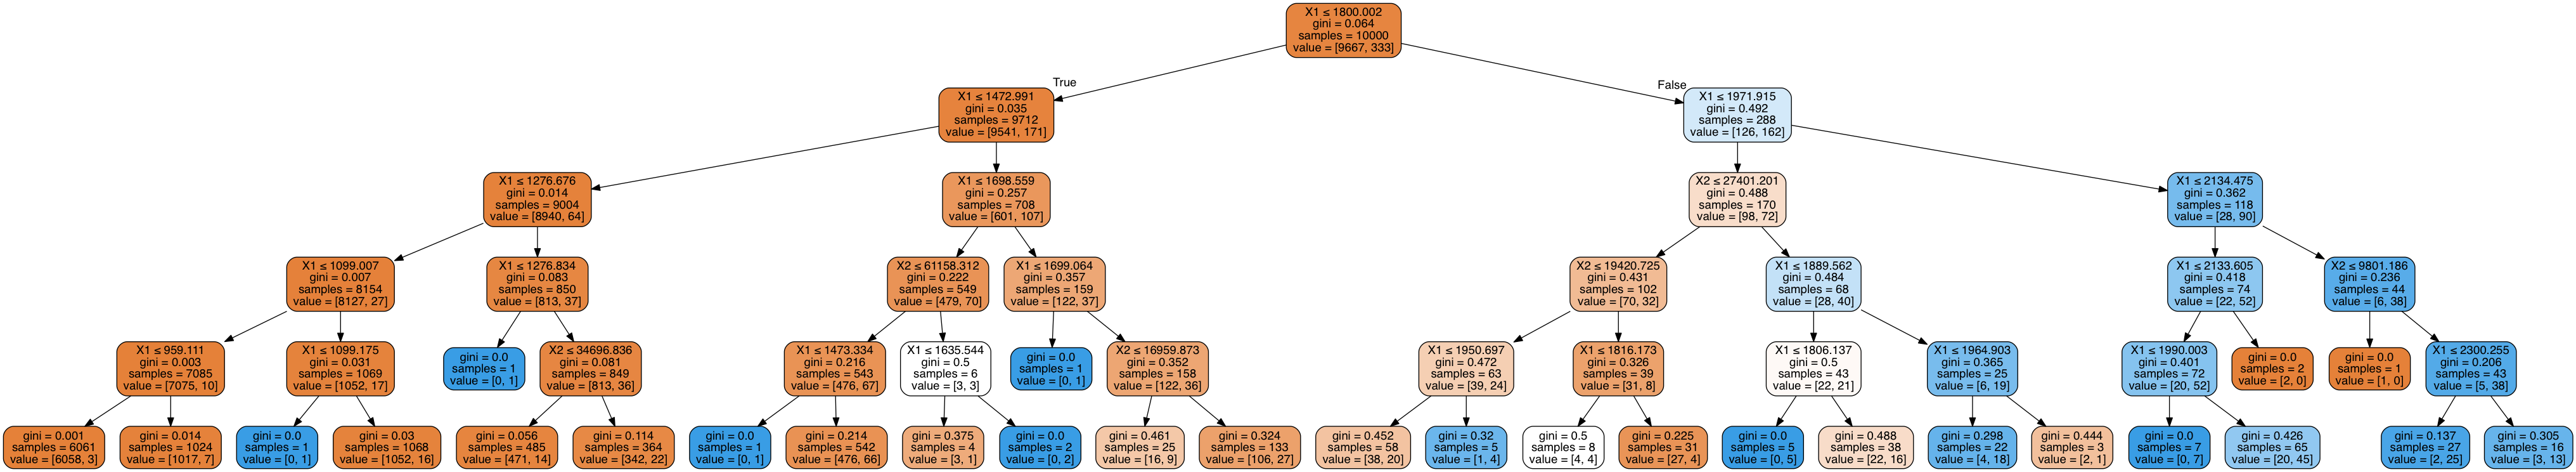

In [128]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
clf = DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X, y)

dot_data = StringIO()

export_graphviz(clf, out_file = dot_data,
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Performance is slightly worse than logistic regression but not bad. 

8) Find the optimal decision tree depth and compute the AUC ROC. 

In [229]:
X = df_final[['student_Yes', 'balance', 'income']]
y = df_final[['default_Yes']]
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 11)

depths = range(1, 11)
scores = []

for depth in depths: 
    tree = DecisionTreeClassifier(max_depth = depth)
    probas_ = tree.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve for depth %i: %f" % (depth, roc_auc))
    scores.append(roc_auc)

best_depth = depths[np.argmax(scores)]
best_roc = max(scores)
print("Best depth is %i with AUC ROC of %f" % (best_depth, best_roc))

Area under the ROC curve for depth 1: 0.755888
Area under the ROC curve for depth 2: 0.849800
Area under the ROC curve for depth 3: 0.910168
Area under the ROC curve for depth 4: 0.921515
Area under the ROC curve for depth 5: 0.906166
Area under the ROC curve for depth 6: 0.884662
Area under the ROC curve for depth 7: 0.888681
Area under the ROC curve for depth 8: 0.859030
Area under the ROC curve for depth 9: 0.816902
Area under the ROC curve for depth 10: 0.755091
Best depth is 4 with AUC ROC of 0.921515


# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 